In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('mushroom_cleaned.csv')
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [3]:
# Data Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
columns = df.columns.tolist()
X_columns = columns[:-1]
y_column = columns[-1]

In [6]:
standart_scaler = StandardScaler()
df[X_columns] = standart_scaler.fit_transform(df[X_columns])

In [7]:
# Split on Train and Test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
rows_to_select = 1000

In [10]:
import random
selected_rows = random.sample(range(0, df.shape[0] - 1), rows_to_select)

In [11]:
X = df[X_columns].iloc[selected_rows]
y = df[y_column].iloc[selected_rows]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [13]:
# Sklearn Algorithm Implementation

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import optuna

In [15]:
def find_best_hyperparameters_for_sklearn_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(find_best_hyperparameters_for_sklearn_knn, n_trials=100)

print('Best params', study.best_params)

[I 2024-06-05 00:29:15,565] A new study created in memory with name: no-name-951ad1f0-c375-4eaf-8549-9236b13bd830
[I 2024-06-05 00:29:15,572] Trial 0 finished with value: 0.77 and parameters: {'n_neighbors': 7, 'weights': 'uniform'}. Best is trial 0 with value: 0.77.
[I 2024-06-05 00:29:15,575] Trial 1 finished with value: 0.855 and parameters: {'n_neighbors': 3, 'weights': 'distance'}. Best is trial 1 with value: 0.855.
[I 2024-06-05 00:29:15,580] Trial 2 finished with value: 0.78 and parameters: {'n_neighbors': 2, 'weights': 'uniform'}. Best is trial 1 with value: 0.855.
[I 2024-06-05 00:29:15,585] Trial 3 finished with value: 0.775 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 1 with value: 0.855.
[I 2024-06-05 00:29:15,593] Trial 4 finished with value: 0.73 and parameters: {'n_neighbors': 9, 'weights': 'uniform'}. Best is trial 1 with value: 0.855.
[I 2024-06-05 00:29:15,596] Trial 5 finished with value: 0.82 and parameters: {'n_neighbors': 5, 'weights': '

Best params {'n_neighbors': 3, 'weights': 'distance'}


In [16]:
model = KNeighborsClassifier(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final Score', accuracy_score(y_test, y_pred))

Final Score 0.855


In [17]:
n_neighbors_list = [n_neighbors for n_neighbors in range(1, 20)]

y_train_list = []
y_test_list = []

for n_neighbors in n_neighbors_list:
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    y_train_list.append(accuracy_score(y_train, y_pred))

    y_pred = model.predict(X_test)
    y_test_list.append(accuracy_score(y_test, y_pred))

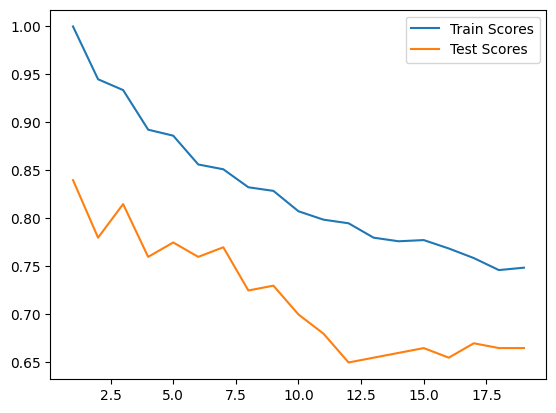

In [18]:
plt.plot(n_neighbors_list, y_train_list, label='Train Scores')
plt.plot(n_neighbors_list, y_test_list, label='Test Scores')
plt.legend()
plt.show()

In [19]:
# My Algorithm Implementation

In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import minkowski, cosine

In [21]:
def uniform_kernel(distances):
    return np.ones_like(distances)

def gaussian_kernel(distances):
    return np.exp(-distances ** 2 / 2.0)

def custom_kernel(distances, a=1, b=1):
    u = np.abs(distances)
    return (1 - u ** a) ** b

def epanechnikov_kernel(distances):
    return np.maximum(1 - distances ** 2, 0)

In [22]:
def minkowski_distance(x1, x2, p=2):
    return np.sum(np.abs(x1 - x2) ** p, axis=-1) ** (1 / p)

def cosine_distance(x1, x2):
    dot_product = np.sum(x1 * x2, axis=-1)
    norm_x1 = np.linalg.norm(x1, axis=-1)
    norm_x2 = np.linalg.norm(x2, axis=-1)
    return 1 - dot_product / (norm_x1 * norm_x2)

def manhattan_distance(x1, x2):
    return np.max(np.abs(x1 - x2))

def custom_distance(x1, x2):
    return np.sum(np.abs(x1 - x2), axis=-1)

In [23]:
class KNN:
    def __init__(
        self, 
        n_neighbors=None, 
        radius=None, 
        metric='minkowski', 
        p=2, 
        kernel='uniform', 
        kernel_params=None, 
        fixed_window=True
    ):
        self.n_neighbors = n_neighbors
        self.radius = radius
        self.metric = metric
        self.p = p
        self.kernel = kernel
        self.kernel_params = kernel_params or {}
        self.fixed_window = fixed_window

    def fit(self, X, y):
        self.X = np.atleast_2d(X)
        self.y = np.array(y)
        if self.y.ndim == 1:
            self.y = self.y[:, np.newaxis]

    def _get_metric(self):
        if self.metric == 'minkowski':
            return lambda x1, x2: minkowski_distance(x1, x2, p=self.p)
        elif self.metric == 'cosine':
            return cosine_distance
        elif self.metric == 'manhattan':
            return manhattan_distance
        else:
            return custom_distance

    def _get_kernel(self):
        if self.kernel == 'uniform':
            return uniform_kernel
        elif self.kernel == 'gaussian':
            return gaussian_kernel
        elif self.kernel == 'custom':
            return lambda distances: custom_kernel(distances, **self.kernel_params)
        else:
            return epanechnikov_kernel

    def predict(self, X, apriori_weights=None):
        X = np.atleast_2d(X)
        if self.n_neighbors is not None:
            knn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self._get_metric())
            knn.fit(self.X)
            distances, indices = knn.kneighbors(X)
        elif self.radius is not None:
            knn = NearestNeighbors(radius=self.radius, metric=self._get_metric())
            knn.fit(self.X)
            distances, indices = knn.radius_neighbors(X)
        else:
            raise ValueError("Either n_neighbors or radius should be provided.")

        results = []
        kernel_func = self._get_kernel()

        for dist, idx in zip(distances, indices):
            if (len(dist) == 0):
                results.append((1, 0.5))
                continue
            weights = kernel_func(np.array(dist)/max(1, np.max(np.array(dist))))
            if apriori_weights is not None:
                weights *= apriori_weights[idx]
                
            label_values = self.y[idx].flatten()
            weighted_labels_sum = np.bincount(label_values.astype(int), weights=weights)
            total_sum = np.sum(weighted_labels_sum)
            
            result = np.argmax(weighted_labels_sum)
            results.append((result, weighted_labels_sum[result]/total_sum))

        return np.array(results)

In [33]:
def find_best_hyperparameters_for_my_knn(trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'manhattan', 'cosine', 'custom'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'custom', 'epanechnikov'])
    fixed_window = trial.suggest_categorical('fixed_window', [True, False])

    if fixed_window:
        radius = trial.suggest_float('radius', 1e-5, 1e-2)
        model = KNN(radius=radius, metric=metric, kernel=kernel, fixed_window=fixed_window)
    else:
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNN(n_neighbors=n_neighbors, metric=metric, kernel=kernel, fixed_window=fixed_window)

    model.fit(X_train, y_train)
    y_pred_to_prob = model.predict(X_test)
    y_pred = [first for (first, second) in y_pred_to_prob]

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(find_best_hyperparameters_for_my_knn, n_trials=10)

best_params = study.best_params
print('Best params', best_params)

[I 2024-06-05 00:30:29,826] A new study created in memory with name: no-name-9f8b6d2f-aba7-4c18-b89e-86e2b535d82b
[I 2024-06-05 00:30:30,176] Trial 0 finished with value: 0.9 and parameters: {'metric': 'custom', 'kernel': 'epanechnikov', 'fixed_window': False, 'n_neighbors': 5}. Best is trial 0 with value: 0.9.
[I 2024-06-05 00:30:30,617] Trial 1 finished with value: 0.75 and parameters: {'metric': 'minkowski', 'kernel': 'gaussian', 'fixed_window': False, 'n_neighbors': 9}. Best is trial 0 with value: 0.9.
[I 2024-06-05 00:30:30,990] Trial 2 finished with value: 0.675 and parameters: {'metric': 'cosine', 'kernel': 'custom', 'fixed_window': True, 'radius': 0.009061080774943414}. Best is trial 0 with value: 0.9.
[I 2024-06-05 00:30:31,494] Trial 3 finished with value: 0.7 and parameters: {'metric': 'cosine', 'kernel': 'epanechnikov', 'fixed_window': False, 'n_neighbors': 11}. Best is trial 0 with value: 0.9.
[I 2024-06-05 00:30:31,964] Trial 4 finished with value: 0.68 and parameters: {'

Best params {'metric': 'custom', 'kernel': 'epanechnikov', 'fixed_window': False, 'n_neighbors': 5}


In [34]:
model = KNN(**study.best_params)
model.fit(X_train, y_train)
y_pred_to_prob = model.predict(X_test)
y_pred = [first for (first, second) in y_pred_to_prob]
print('Final Score', accuracy_score(y_test, y_pred))

Final Score 0.9


In [35]:
n_neighbors_list = [n_neighbors for n_neighbors in range(1, 20)]

y_train_list = []
y_test_list = []

for n_neighbors in n_neighbors_list:
    model = KNN(n_neighbors=n_neighbors, metric='euclidean')
    model.fit(X_train, y_train)

    y_pred = [first for (first, second) in model.predict(X_train)]
    y_train_list.append(accuracy_score(y_train, y_pred))

    y_pred = [first for (first, second) in model.predict(X_test)]
    y_test_list.append(accuracy_score(y_test, y_pred))

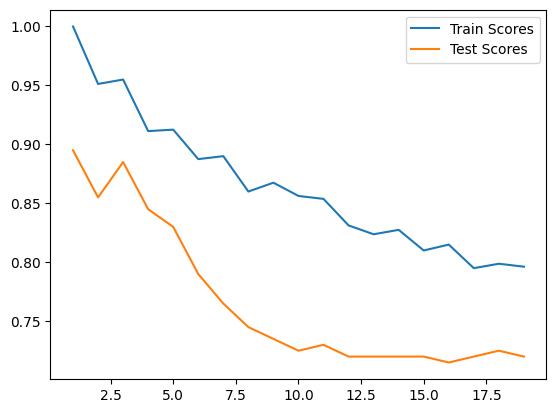

In [36]:
plt.plot(n_neighbors_list, y_train_list, label='Train Scores')
plt.plot(n_neighbors_list, y_test_list, label='Test Scores')
plt.legend()
plt.show()

In [37]:
# Lowess

In [39]:
knn = KNN(**study.best_params)
weights = np.ones(len(X_train))

while True:
    cur_weights = []
    for index in range(len(X_train)):
        x_without_one = np.delete(X_train, index, axis=0)
        y_without_one = np.delete(y_train, index, axis=0)
        knn.fit(x_without_one, y_without_one)
        (y_pred, prob) = knn.predict(X_train[index], weights)[0]
        if (y_pred != y_train[index]):
            prob = 1-prob
        cur_weights.append(1-prob)
    cur_weights = gaussian_kernel(np.array(cur_weights))

    should_continue = False
    for index in range(len(X_train)):
        if abs(weights[index] - cur_weights[index]) > 0.0001:
            should_continue = True

    weights = cur_weights
    if not should_continue:
        break

knn.fit(X_train, y_train)

y_pred = [first for (first, second) in knn.predict(X_test)]
print('With no weights:', accuracy_score(y_test, y_pred))

print('Weights:', weights)
y_pred = [first for (first, second) in knn.predict(X_test, weights)]
print('With gaussian kernel:', accuracy_score(y_test, y_pred))

With no weights: 0.9
Weights: [0.96200017 0.9979126  0.93138594 1.         1.         1.
 1.         0.9995305  0.74016487 1.         1.         0.93447469
 1.         0.6738879  1.         1.         1.         0.91228376
 1.         0.91332947 1.         0.87713727 0.9900387  1.
 1.         0.98665865 0.99326402 1.         1.         1.
 0.96125788 1.         1.         1.         0.77860708 1.
 1.         0.99916968 1.         1.         0.96116995 0.94552005
 1.         1.         0.97302835 0.99400083 1.         1.
 0.91645213 1.         0.99967847 0.87243475 1.         1.
 1.         0.99578062 0.77885797 1.         0.83654912 1.
 0.99382004 0.98148648 0.67741451 0.99895533 0.92091753 0.85381443
 1.         0.96742595 1.         1.         1.         0.92015772
 1.         0.7945986  1.         0.92804926 1.         0.97836864
 1.         1.         1.         1.         1.         0.96760927
 1.         0.99396842 1.         1.         0.91073497 0.99362608
 0.94389645 1.       